In [1]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [3]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

In [4]:
# Load data
train = pd.read_csv('../public_data_test/track_a/train/eng.csv')
val = pd.read_csv('../public_data_test/track_a/dev/eng.csv')
test = pd.read_csv('../public_data_test/track_a/test/eng.csv')

# Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [5]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [6]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
emolex_path = "../NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [8]:
def load_emolex(emolex_path):
    emolex = pd.read_csv(emolex_path, sep='\t', header=None, names=["Word", "Emotion", "Association"])
    # Filter to only include our target emotions
    emolex = emolex[emolex['Emotion'].isin(emotions)]
    
    emotion_dict = {}
    for _, row in emolex.iterrows():
        if row["Association"] == 1:  # Only positive associations
            word = row["Word"].lower()  # Convert to lowercase
            emotion = row["Emotion"].lower()
            if word not in emotion_dict:
                emotion_dict[word] = []
            emotion_dict[word].append(emotion)
    
    print(f"Loaded {len(emotion_dict)} words from EmoLex")
    return emotion_dict

emotion_dict = load_emolex(emolex_path)

Loaded 3155 words from EmoLex


In [9]:
nlp = spacy.load("en_core_web_sm")

# Initialize emotion_matches globally before preprocessing
emotion_matches = {emotion: 0 for emotion in emotions}

for emotion in emotions:
    emotion_words = [word for word, emots in emotion_dict.items() if emotion in emots]
    print(f"\n{emotion} words in lexicon: {len(emotion_words)}")
    print("Sample words:", emotion_words[:5])

# During preprocessing
def pre_process(text, config, target_emotion, emotion_dict):
    global emotion_matches  # Reference the global variable
    
    original_text = text  # Save original text for EmoLex matching

    # First do EmoLex matching on original text
    emolex_words = []
    if target_emotion and emotion_dict:
        # Convert text to lowercase for matching
        text_lower = original_text.lower()
        # Find words that appear in both text and emotion lexicon
        text_words = set(text_lower.split())
        emolex_words = [word for word in text_words 
                       if word in emotion_dict 
                       and target_emotion in emotion_dict[word]]
        
        if emolex_words:
            emotion_matches[target_emotion] += 1

    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    processed_text = " ".join(tokens)

    # Finally, append EmoLex words if found
    if emolex_words:
        processed_text = f"{processed_text} [SEP] {' '.join(emolex_words)}"
    else:
        processed_text = f"{processed_text} [SEP]"
    
    return processed_text

# After preprocessing
print("\nEmotion word matches in training data:")
for emotion in emotions:
    print(f"{emotion}: {emotion_matches[emotion]} texts")


joy words in lexicon: 687
Sample words: ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment']

sadness words in lexicon: 1187
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abortion']

surprise words in lexicon: 532
Sample words: ['abandonment', 'abduction', 'abrupt', 'accident', 'accidental']

fear words in lexicon: 1474
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abhor']

anger words in lexicon: 1245
Sample words: ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish']

Emotion word matches in training data:
joy: 0 texts
sadness: 0 texts
surprise: 0 texts
fear: 0 texts
anger: 0 texts


In [10]:
# Vectorizer Definition
vectorizer = CountVectorizer()

In [11]:
# Reset emotion_matches before processing dataset
def preprocess_dataset_with_emotions(dataset, emotions, config, emotion_dict):
    global emotion_matches
    emotion_matches = {emotion: 0 for emotion in emotions}  # Reset counters
    
    augmented_data = {}
    
    # Process for each emotion
    for emotion in emotions:
        print(f"\nProcessing {emotion}:")
        texts = []
        for text in tqdm(dataset):
            processed = pre_process(text, config, target_emotion=emotion, emotion_dict=emotion_dict)
            texts.append(processed)
            
        # Count how many texts contain emotion-specific words
        emotion_word_count = sum(1 for text in texts if '[SEP]' in text and not text.endswith('[SEP]'))
        print(f"Texts with {emotion}-specific words: {emotion_matches[emotion]}/{len(texts)}")
        
        augmented_data[emotion] = texts
    
    return augmented_data

train_augmented = preprocess_dataset_with_emotions(train["text"], emotions, config, emotion_dict)
val_augmented = preprocess_dataset_with_emotions(val["text"], emotions, config, emotion_dict)
test_augmented = preprocess_dataset_with_emotions(test["text"], emotions, config, emotion_dict)

# Fit the vectorizer on the combined training data
vectorizer = CountVectorizer()
vectorizer.fit(train_augmented['joy'] + train_augmented['sadness'] + train_augmented['surprise'] + train_augmented['fear'] + train_augmented['anger'])

# Transform each emotion separately
X_train = {emotion: vectorizer.transform(train_augmented[emotion]).toarray() for emotion in emotions}
X_val = {emotion: vectorizer.transform(val_augmented[emotion]).toarray() for emotion in emotions}
X_test = {emotion: vectorizer.transform(test_augmented[emotion]).toarray() for emotion in emotions}


Processing joy:


100%|██████████| 2768/2768 [00:03<00:00, 780.05it/s] 


Texts with joy-specific words: 461/2768

Processing sadness:


100%|██████████| 2768/2768 [00:01<00:00, 2072.94it/s]


Texts with sadness-specific words: 569/2768

Processing surprise:


100%|██████████| 2768/2768 [00:01<00:00, 2093.13it/s]


Texts with surprise-specific words: 318/2768

Processing fear:


100%|██████████| 2768/2768 [00:01<00:00, 1994.61it/s]


Texts with fear-specific words: 520/2768

Processing anger:


100%|██████████| 2768/2768 [00:01<00:00, 2094.20it/s]


Texts with anger-specific words: 463/2768

Processing joy:


100%|██████████| 116/116 [00:00<00:00, 2065.16it/s]


Texts with joy-specific words: 19/116

Processing sadness:


100%|██████████| 116/116 [00:00<00:00, 2075.02it/s]


Texts with sadness-specific words: 22/116

Processing surprise:


100%|██████████| 116/116 [00:00<00:00, 2072.43it/s]


Texts with surprise-specific words: 15/116

Processing fear:


100%|██████████| 116/116 [00:00<00:00, 2074.77it/s]


Texts with fear-specific words: 21/116

Processing anger:


100%|██████████| 116/116 [00:00<00:00, 2073.33it/s]


Texts with anger-specific words: 17/116

Processing joy:


100%|██████████| 2767/2767 [00:01<00:00, 2057.09it/s]


Texts with joy-specific words: 453/2767

Processing sadness:


100%|██████████| 2767/2767 [00:01<00:00, 2067.60it/s]


Texts with sadness-specific words: 537/2767

Processing surprise:


100%|██████████| 2767/2767 [00:01<00:00, 1786.63it/s]


Texts with surprise-specific words: 349/2767

Processing fear:


100%|██████████| 2767/2767 [00:01<00:00, 2066.84it/s]


Texts with fear-specific words: 531/2767

Processing anger:


100%|██████████| 2767/2767 [00:01<00:00, 2034.33it/s]


Texts with anger-specific words: 438/2767


In [14]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [15]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu
/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [16]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [17]:
# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

In [18]:
# Get BERT embeddings for training data
print("Getting training BERT embeddings...")
train_raw_preds = get_predictions_batch(train['text'].tolist())
train_bert_features = format_predictions(train_raw_preds, emotion_mapping)

print("Getting validation BERT embeddings...")
val_raw_preds = get_predictions_batch(val['text'].tolist())
val_bert_features = format_predictions(val_raw_preds, emotion_mapping)

print("Getting test BERT embeddings...")
test_raw_preds = get_predictions_batch(test['text'].tolist())
test_bert_features = format_predictions(test_raw_preds, emotion_mapping)

# Get POS features
print("Extracting POS features...")
train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])
test_pos_tags = extract_pos_tags(test["text"])

# POS Encoding
max_length = max(
    max(len(tags) for tags in train_pos_tags),
    max(len(tags) for tags in val_pos_tags),
    max(len(tags) for tags in test_pos_tags)
)
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]
test_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in test_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)
test_pos_encoded = encoder.transform(test_pos_tags)

Getting training BERT embeddings...


Predicting: 100%|██████████| 87/87 [03:24<00:00,  2.35s/it]


Getting validation BERT embeddings...


Predicting: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Getting test BERT embeddings...


Predicting: 100%|██████████| 87/87 [03:34<00:00,  2.47s/it]


Extracting POS features...


In [19]:
for emotion in emotions:
    print(f"Emotion: {emotion}")
    print(f"Train Vectorizer Shape: {X_train[emotion].shape}")
    print(f"Val Vectorizer Shape: {X_val[emotion].shape}")
    print(f"Train BERT Shape: {train_bert_features.shape}")
    print(f"Val BERT Shape: {val_bert_features.shape}")
    print(f"Train POS Shape: {train_pos_encoded.shape}")
    print(f"Val POS Shape: {val_pos_encoded.shape}")

Emotion: joy
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: sadness
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: surprise
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: fear
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)
Emotion: anger
Train Vectorizer Shape: (2768, 4340)
Val Vectorizer Shape: (116, 4340)
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Train POS Shape: (2768, 1176)
Val POS Shape: (116, 1176)


In [20]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [21]:
# Combine features for each emotion separately
final_train_features = {}
final_val_features = {}
final_test_features = {}

print("Combining features for each emotion...")
for emotion in emotions:
    print(f"\nProcessing {emotion}:")
    print(f"X_train shape: {X_train[emotion].shape}")
    print(f"train_bert_features shape: {train_bert_features.shape}")
    print(f"train_pos_encoded shape: {train_pos_encoded.shape}")
    
    final_train_features[emotion] = np.hstack([
        X_train[emotion],
        train_bert_features,
        train_pos_encoded
    ])
    
    final_val_features[emotion] = np.hstack([
        X_val[emotion],
        val_bert_features,
        val_pos_encoded
    ])
    
    final_test_features[emotion] = np.hstack([
        X_test[emotion],
        test_bert_features,
        test_pos_encoded
    ])
    
    print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

Combining features for each emotion...

Processing joy:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for joy: (2768, 5521)

Processing sadness:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for sadness: (2768, 5521)

Processing surprise:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for surprise: (2768, 5521)

Processing fear:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for fear: (2768, 5521)

Processing anger:
X_train shape: (2768, 4340)
train_bert_features shape: (2768, 5)
train_pos_encoded shape: (2768, 1176)
Final features shape for anger: (2768, 5521)


In [22]:
# Create a model for each emotion
models = {}
for emotion in emotions:
    input_size = final_train_features[emotion].shape[1]  # Get the feature size for each emotion
    models[emotion] = nn.Sequential(
        nn.Linear(input_size, 256),  # Use the correct input size
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

In [23]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [24]:
for emotion in emotions:

    print(f"Feature size for {emotion}: {final_train_features[emotion].shape[1]}")

Feature size for joy: 5521
Feature size for sadness: 5521
Feature size for surprise: 5521
Feature size for fear: 5521
Feature size for anger: 5521


/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for joy
Validation features shape for joy: torch.Size([116, 5521])


Training Loop (joy):   0%|          | 0/401 [00:00<?, ?it/s]

Training Loop (joy):   0%|          | 1/401 [00:03<24:43,  3.71s/it]


Epoch 0 (joy):
Training Loss: 0.9598, Validation Loss: 0.9201
Macro F1: 0.6405

New best model for joy at epoch 0 with F1: 0.6405


Training Loop (joy):   0%|          | 2/401 [00:07<26:05,  3.92s/it]


New best model for joy at epoch 1 with F1: 0.7432


Training Loop (joy):   1%|          | 5/401 [00:15<17:58,  2.72s/it]


New best model for joy at epoch 4 with F1: 0.7613


Training Loop (joy):   3%|▎         | 11/401 [00:29<16:53,  2.60s/it]


Epoch 10 (joy):
Training Loss: 0.0640, Validation Loss: 2.0185
Macro F1: 0.6665


Training Loop (joy):   3%|▎         | 14/401 [00:39<18:13,  2.82s/it]


Early stopping triggered at epoch 14

Loaded best model for joy from epoch 4 with F1: 0.7613



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/4006872239.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoi

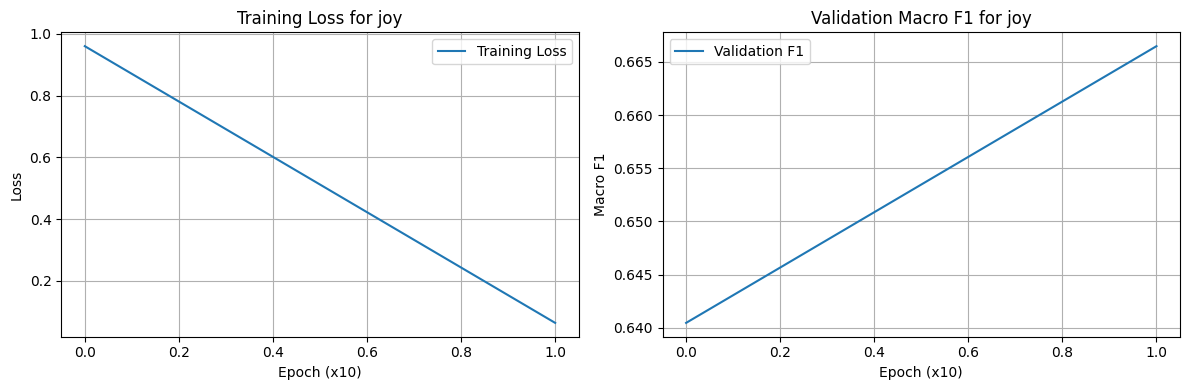

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for sadness
Validation features shape for sadness: torch.Size([116, 5521])


Training Loop (sadness):   0%|          | 1/401 [00:02<18:03,  2.71s/it]


Epoch 0 (sadness):
Training Loss: 0.9011, Validation Loss: 0.7543
Macro F1: 0.7138

New best model for sadness at epoch 0 with F1: 0.7138


Training Loop (sadness):   0%|          | 2/401 [00:05<17:48,  2.68s/it]


New best model for sadness at epoch 1 with F1: 0.7302


Training Loop (sadness):   1%|          | 5/401 [00:13<18:41,  2.83s/it]


New best model for sadness at epoch 4 with F1: 0.7504


Training Loop (sadness):   2%|▏         | 7/401 [00:20<21:01,  3.20s/it]


New best model for sadness at epoch 6 with F1: 0.7882


Training Loop (sadness):   3%|▎         | 11/401 [00:32<18:12,  2.80s/it]


Epoch 10 (sadness):
Training Loss: 0.0575, Validation Loss: 1.1649
Macro F1: 0.7471


Training Loop (sadness):   4%|▍         | 16/401 [00:46<18:48,  2.93s/it]


Early stopping triggered at epoch 16

Loaded best model for sadness from epoch 6 with F1: 0.7882



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/4006872239.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoi

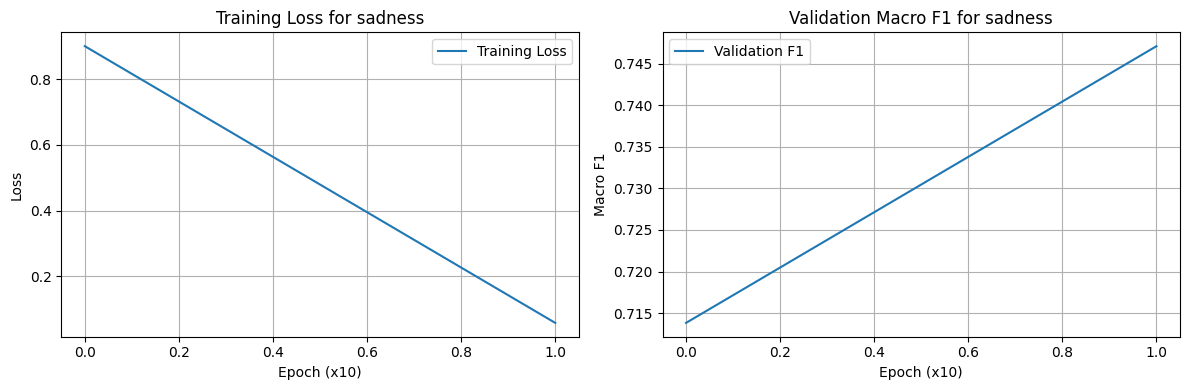

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for surprise
Validation features shape for surprise: torch.Size([116, 5521])


Training Loop (surprise):   0%|          | 1/401 [00:02<17:10,  2.58s/it]


Epoch 0 (surprise):
Training Loss: 0.8572, Validation Loss: 0.8133
Macro F1: 0.6576

New best model for surprise at epoch 0 with F1: 0.6576


Training Loop (surprise):   0%|          | 2/401 [00:04<14:34,  2.19s/it]


New best model for surprise at epoch 1 with F1: 0.6674


Training Loop (surprise):   1%|          | 3/401 [00:06<14:18,  2.16s/it]


New best model for surprise at epoch 2 with F1: 0.6705


Training Loop (surprise):   2%|▏         | 7/401 [00:14<12:57,  1.97s/it]


New best model for surprise at epoch 6 with F1: 0.7026


Training Loop (surprise):   3%|▎         | 11/401 [00:22<13:14,  2.04s/it]


Epoch 10 (surprise):
Training Loss: 0.0519, Validation Loss: 1.4787
Macro F1: 0.6469


Training Loop (surprise):   4%|▍         | 17/401 [00:34<12:48,  2.00s/it]


New best model for surprise at epoch 16 with F1: 0.7188


Training Loop (surprise):   5%|▌         | 21/401 [00:43<15:35,  2.46s/it]


Epoch 20 (surprise):
Training Loss: 0.0135, Validation Loss: 1.8300
Macro F1: 0.7093


Training Loop (surprise):   7%|▋         | 27/401 [01:01<17:16,  2.77s/it]


New best model for surprise at epoch 26 with F1: 0.7276


Training Loop (surprise):   8%|▊         | 31/401 [01:08<12:37,  2.05s/it]


Epoch 30 (surprise):
Training Loss: 0.0052, Validation Loss: 1.7746
Macro F1: 0.6853


Training Loop (surprise):   9%|▉         | 36/401 [01:24<14:19,  2.36s/it]


Early stopping triggered at epoch 36

Loaded best model for surprise from epoch 26 with F1: 0.7276



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/4006872239.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoi

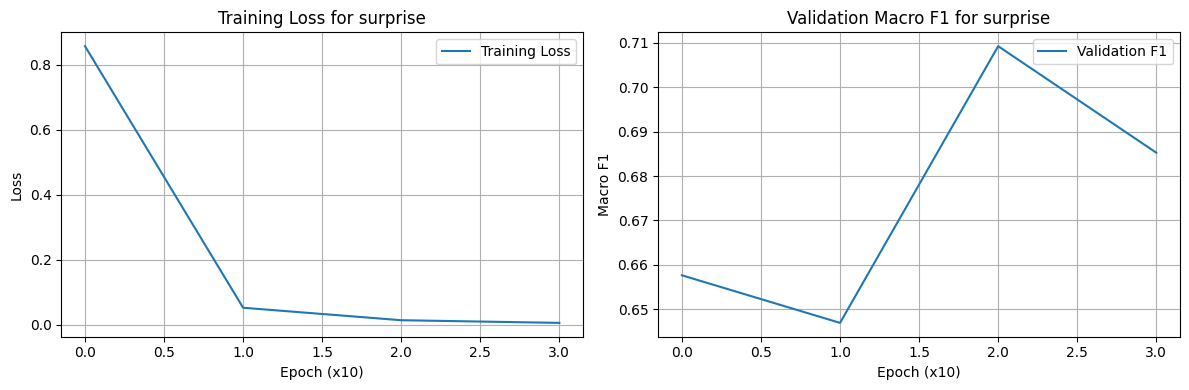

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for fear
Validation features shape for fear: torch.Size([116, 5521])


Training Loop (fear):   0%|          | 1/401 [00:01<13:02,  1.96s/it]


Epoch 0 (fear):
Training Loss: 0.5357, Validation Loss: 0.5636
Macro F1: 0.5937

New best model for fear at epoch 0 with F1: 0.5937


Training Loop (fear):   0%|          | 2/401 [00:03<13:06,  1.97s/it]


New best model for fear at epoch 1 with F1: 0.6551


Training Loop (fear):   1%|          | 3/401 [00:05<12:53,  1.94s/it]


New best model for fear at epoch 2 with F1: 0.6595


Training Loop (fear):   1%|          | 4/401 [00:07<12:44,  1.93s/it]


New best model for fear at epoch 3 with F1: 0.6636


Training Loop (fear):   3%|▎         | 11/401 [00:22<14:19,  2.20s/it]


Epoch 10 (fear):
Training Loss: 0.0292, Validation Loss: 0.8804
Macro F1: 0.6545


Training Loop (fear):   3%|▎         | 13/401 [00:29<14:27,  2.24s/it]


Early stopping triggered at epoch 13

Loaded best model for fear from epoch 3 with F1: 0.6636



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/4006872239.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoi

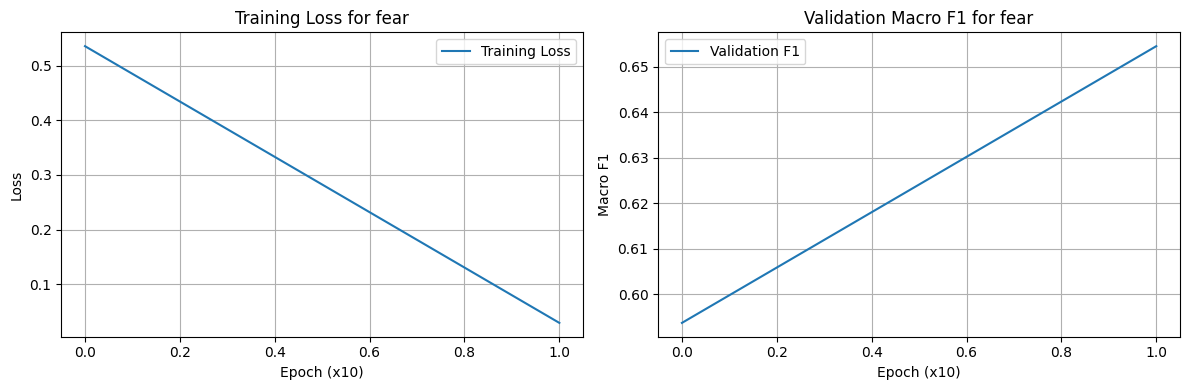

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for anger
Validation features shape for anger: torch.Size([116, 5521])


Training Loop (anger):   0%|          | 1/401 [00:02<14:44,  2.21s/it]


Epoch 0 (anger):
Training Loss: 1.1763, Validation Loss: 1.1311
Macro F1: 0.5533

New best model for anger at epoch 0 with F1: 0.5533


Training Loop (anger):   0%|          | 2/401 [00:04<13:56,  2.10s/it]


New best model for anger at epoch 1 with F1: 0.6354


Training Loop (anger):   1%|          | 3/401 [00:06<13:59,  2.11s/it]


New best model for anger at epoch 2 with F1: 0.6593


Training Loop (anger):   1%|          | 4/401 [00:08<13:51,  2.09s/it]


New best model for anger at epoch 3 with F1: 0.7281


Training Loop (anger):   3%|▎         | 11/401 [00:22<12:24,  1.91s/it]


Epoch 10 (anger):
Training Loss: 0.0528, Validation Loss: 2.3922
Macro F1: 0.6968


Training Loop (anger):   3%|▎         | 13/401 [00:27<13:52,  2.15s/it]


Early stopping triggered at epoch 13

Loaded best model for anger from epoch 3 with F1: 0.7281



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/4006872239.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoi

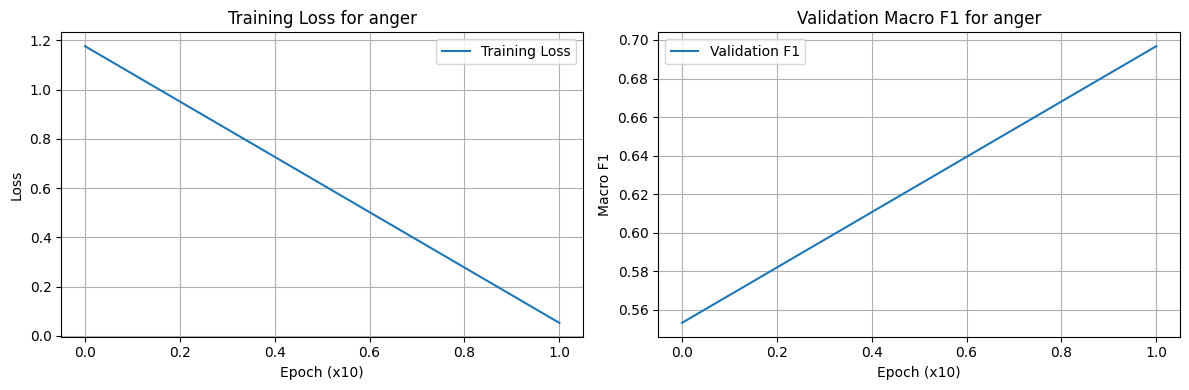

In [25]:
for emotion in emotions:
    print(f"\nTraining model for {emotion}")
    model = models[emotion]
    model.train()  # Add this to explicitly set training mode
    
    # Prepare data for this emotion
    features_tensor = torch.tensor(final_train_features[emotion], dtype=torch.float32)
    labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    
    # Add validation tensors
    val_features_tensor = torch.tensor(final_val_features[emotion], dtype=torch.float32)
    val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    print(f"Validation features shape for {emotion}: {val_features_tensor.shape}")
    
    dataset = TensorDataset(features_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Increased batch size

    # Calculate class weights for this emotion
    pos_weight = (len(labels_tensor) - labels_tensor.sum()) / labels_tensor.sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Better handling of class imbalance
    
    # Use Adam optimizer with learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Training loop
    best_f1 = 0
    patience = 10
    patience_counter = 0
    train_losses = []
    val_f1s = []
    
    for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for features, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

            # Adversarial training
            epsilon = 0.01  # Small perturbation value
            features.requires_grad = True
            outputs_adv = model(features)
            loss_adv = criterion(outputs_adv, labels)
            model.zero_grad()
            loss_adv.backward()
            data_grad = features.grad.data
            perturbed_data = features + epsilon * data_grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Ensure data is valid

            # Re-run the model with perturbed data
            outputs_perturbed = model(perturbed_data)
            loss_perturbed = criterion(outputs_perturbed, labels)
            loss_perturbed.backward()
            optimizer.step()

        avg_train_loss = epoch_loss / batch_count
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_preds = (torch.sigmoid(val_outputs).squeeze() > 0.5).float()
            val_labels = val_labels_tensor.squeeze()
            
            # Calculate metrics
            val_loss = criterion(val_outputs, val_labels_tensor)
            macro_f1 = f1_score(
                val_labels.cpu().numpy(),
                val_preds.cpu().numpy(),
                average='macro',
                zero_division=0
            )

        # Learning rate scheduling
        scheduler.step(macro_f1)

        if epoch % 10 == 0:  # More frequent logging
            print(f'\nEpoch {epoch} ({emotion}):')
            print(f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Macro F1: {macro_f1:.4f}')
            train_losses.append(avg_train_loss)
            val_f1s.append(macro_f1)
        
        # Save best model
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'f1': macro_f1
            }, f'./model_checkpoints/{emotion}_best.pth')
            print(f"\nNew best model for {emotion} at epoch {epoch} with F1: {macro_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Load best model for this emotion
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model for {emotion} from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.title(f'Training Loss for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
    plt.title(f'Validation Macro F1 for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Macro F1')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [26]:
# # Training loop for each emotion
# for emotion in emotions:
#     print(f"\nTraining model for {emotion}")
#     model = models[emotion]
    
#     # Prepare data for this emotion
#     features_tensor = torch.tensor(final_train_features[emotion], dtype=torch.float32)
#     labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
#     dataset = TensorDataset(features_tensor, labels_tensor)
#     data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

#     # Calculate class weights for this emotion
#     class_count = y_train[:, emotions.index(emotion)].sum()
#     total_count = y_train.shape[0]
#     weights = total_count / class_count

#     criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weights], dtype=torch.float32))
#     optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-4)

#     # Training loop
#     losses = []
#     for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
#         for features, labels in data_loader:
#             optimizer.zero_grad()
#             outputs = model(features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         if epoch % 100 == 0:
#             print(f'Epoch {epoch} ({emotion}): Loss: {round(loss.item(),3)}')
#             torch.save(model.state_dict(), f'./model_checkpoints/{emotion}_net_epoch_{epoch}.pth')
#             print(f"Saved epoch {epoch} weights for {emotion}")
#             losses.append(round(loss.item(),3))

#     # Optional: Plot losses for this emotion
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(0, 401, 100), losses)
#     plt.title(f'Training Loss for {emotion}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.grid(True)
#     plt.show()

### Complete same training loop for all emotions using macro F1 score

In [27]:
# from sklearn.metrics import f1_score, jaccard_score, classification_report

# # Dictionary to store best models based on macro F1
# best_models = {emotion: {'model': None, 'f1': 0, 'epoch': 0} for emotion in emotions}

# for emotion in emotions:
#     print(f"\nTraining model for {emotion}")
#     model = models[emotion]
    
#     # Prepare data for this emotion
#     features_tensor = torch.tensor(final_train_features[emotion], dtype=torch.float32)  # Keep emotion-specific features
#     labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
#     dataset = TensorDataset(features_tensor, labels_tensor)
#     data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

#     # Prepare validation data
#     val_features_tensor = torch.tensor(final_val_features[emotion], dtype=torch.float32)
#     val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)

#     # Calculate class weights for this emotion
#     class_count = y_train[:, emotions.index(emotion)].sum()
#     total_count = y_train.shape[0]
#     weights = total_count / class_count

#     criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weights], dtype=torch.float32))
#     optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-4)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)  # Changed to max mode

#     # Training loop
#     best_f1 = 0  # Initialize best_f1 for this emotion
#     patience = 10
#     patience_counter = 0
#     train_losses = []
#     val_f1s = []

#     for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
#         # Training phase
#         model.train()
#         epoch_loss = 0
#         batch_count = 0
        
#         for features, labels in data_loader:
#             optimizer.zero_grad()
#             outputs = model(features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#             batch_count += 1

#         avg_train_loss = epoch_loss / batch_count

#         # Validation phase
#         model.eval()
#         with torch.no_grad():
#             val_outputs = model(val_features_tensor)
#             # Fix 1: Use squeeze() to match dimensions
#             val_preds = (torch.sigmoid(val_outputs).squeeze().numpy() > 0.5).astype(int)
#             val_labels = val_labels_tensor.squeeze().numpy()
            
#             # Fix 2: Calculate macro F1 properly
#             macro_f1 = f1_score(
#                 val_labels,
#                 val_preds,
#                 average='macro',
#                 zero_division=0  # Handle cases with no positive labels
#             )

#         # Learning rate scheduling based on F1
#         scheduler.step(macro_f1)

#         if epoch % 100 == 0:
#             print(f'Epoch {epoch} ({emotion}):')
#             print(f'Training Loss: {avg_train_loss:.3f}, Macro F1: {macro_f1:.3f}')
#             train_losses.append(avg_train_loss)
#             val_f1s.append(macro_f1)
        
#         # Fix 3: Update best_f1 when saving best model
#         if macro_f1 > best_f1:
#             best_f1 = macro_f1  # Update best_f1
#             best_models[emotion]['f1'] = macro_f1
#             torch.save(model.state_dict(), 
#                       f'./model_checkpoints/{emotion}_best_f1_epoch_{epoch}.pth')
#             best_models[emotion]['epoch'] = epoch
#             best_models[emotion]['model'] = model.state_dict().copy()
#             print(f"New best model for {emotion} at epoch {epoch} with F1: {macro_f1:.3f}")
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         # Early stopping
#         if patience_counter >= patience:
#             print(f"Early stopping triggered at epoch {epoch}")
#             break

#     # Plot training curves
#     plt.figure(figsize=(10, 5))
    
#     # Plot training loss with correct epoch numbers
#     plt.subplot(1, 2, 1)
#     epochs = [i*100 for i in range(len(train_losses))]  # Create epoch numbers (0, 100, 200, etc.)
#     plt.plot(epochs, train_losses, marker='o')  # Added markers to better see the points
#     plt.title(f'Training Loss for {emotion}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.grid(True)
    
#     # Plot validation F1 with correct epoch numbers
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, val_f1s, marker='o')  # Added markers to better see the points
#     plt.title(f'Validation Macro F1 for {emotion}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Macro F1')
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.show()

#     print(f"\nBest macro F1 for {emotion}: {best_f1:.3f}")  # Now uses correct best_f1

In [28]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')


Generating predictions for all emotions...
Using best joy model from epoch 4 with F1: 0.761


/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_40286/184351224.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoints

Using best sadness model from epoch 6 with F1: 0.788
Using best surprise model from epoch 26 with F1: 0.728
Using best fear model from epoch 3 with F1: 0.664
Using best anger model from epoch 3 with F1: 0.728

Performing threshold grid search...


Testing thresholds:   0%|          | 0/16 [00:00<?, ?it/s]/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
 


Best Results:
Best threshold: 0.500
Best Macro F1: 0.633


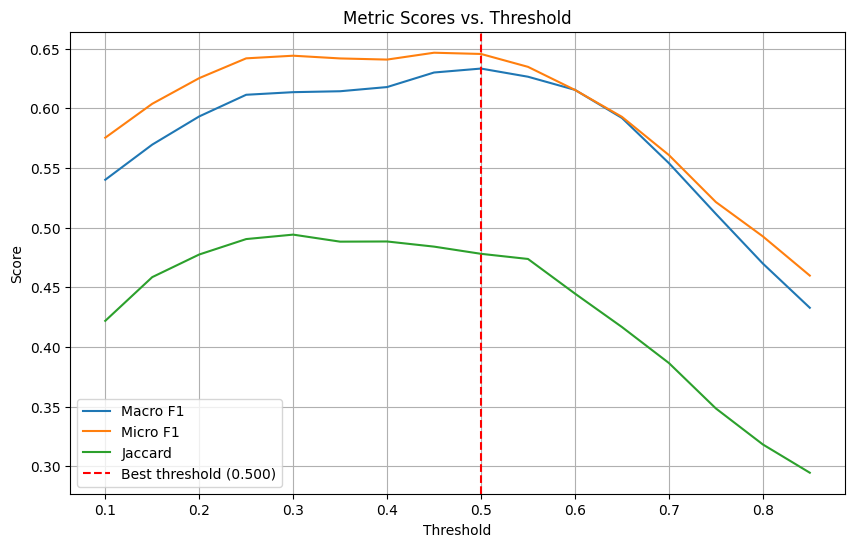

/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Validation Performance with Best Threshold:
              precision    recall  f1-score   support

         joy       0.68      0.61      0.64        31
     sadness       0.74      0.66      0.70        35
    surprise       0.59      0.61      0.60        31
        fear       0.71      0.63      0.67        63
       anger       0.46      0.69      0.55        16

   micro avg       0.65      0.64      0.65       176
   macro avg       0.64      0.64      0.63       176
weighted avg       0.67      0.64      0.65       176
 samples avg       0.60      0.59      0.56       176

Saved predictions to ../results/val_predictions_threshold_0.500_2025-01-31_21_34_56.csv
Saved predictions to ../results/test_predictions_threshold_0.500_2025-01-31_21_34_56.csv

Per-emotion performance at best threshold:
joy: F1 = 0.644
sadness: F1 = 0.697
surprise: F1 = 0.603
fear: F1 = 0.672
anger: F1 = 0.550


In [29]:
# After training loop finishes for all emotions...

# Make predictions for each emotion using best models
print("\nGenerating predictions for all emotions...")
val_preds = {}
test_preds = {}

for emotion in emotions:
    # Load the best model for this emotion
    model = models[emotion]
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"Using best {emotion} model from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.3f}")
    
    with torch.no_grad():
        # Get raw probabilities using sigmoid
        val_outputs = model(torch.tensor(final_val_features[emotion], dtype=torch.float32))
        val_probs = torch.sigmoid(val_outputs).numpy()
        val_preds[emotion] = val_probs
        
        test_outputs = model(torch.tensor(final_test_features[emotion], dtype=torch.float32))
        test_probs = torch.sigmoid(test_outputs).numpy()
        test_preds[emotion] = test_probs

# Combine predictions
val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# Grid search for optimal threshold
print("\nPerforming threshold grid search...")
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0
best_macro_f1 = 0
results = []

for threshold in tqdm(thresholds, desc="Testing thresholds"):
    # Convert probabilities to binary predictions
    val_binary_preds = (val_probs > threshold).astype(int)
    
    # Calculate metrics
    macro_f1 = f1_score(val[emotions].values, val_binary_preds, average='macro')
    micro_f1 = f1_score(val[emotions].values, val_binary_preds, average='micro')
    jaccard = jaccard_score(val[emotions].values, val_binary_preds, average='samples')
    
    results.append({
        'threshold': threshold,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'jaccard': jaccard
    })
    
    # Update best threshold if we found better macro F1
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nBest Results:")
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best Macro F1: {best_macro_f1:.3f}")

# Plot the threshold search results
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
plt.plot(results_df['threshold'], results_df['micro_f1'], label='Micro F1')
plt.plot(results_df['threshold'], results_df['jaccard'], label='Jaccard')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metric Scores vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Generate final predictions using best threshold
val_binary_preds = (val_probs > best_threshold).astype(int)
test_binary_preds = (test_probs > best_threshold).astype(int)

# Print detailed performance report
print("\nFinal Validation Performance with Best Threshold:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions
))

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

# Save validation predictions
save_predictions(
    val_binary_preds,
    val['id'],
    f'../results/val_predictions_threshold_{best_threshold:.3f}_{timestamp}.csv'
)

# Save test predictions
save_predictions(
    test_binary_preds,
    test['id'],
    f'../results/test_predictions_threshold_{best_threshold:.3f}_{timestamp}.csv'
)

# Save threshold search results
results_df.to_csv(f'../results/threshold_search_results_{timestamp}.csv', index=False)

# Print per-emotion performance
print("\nPer-emotion performance at best threshold:")
for i, emotion in enumerate(emotions):
    emotion_f1 = f1_score(
        val[emotions].values[:, i],
        val_binary_preds[:, i],
        average='binary'
    )
    print(f"{emotion}: F1 = {emotion_f1:.3f}")

Scores for Test Set:


Macro F1	0.5399

Micro F1	0.5804

Anger	0.3858

Fear	0.7015

Joy	0.5301

Sadness	0.5427

Surprise	0.5392


In [30]:
# # After training loop finishes for all emotions...

# # Make predictions for each emotion using best models
# print("\nGenerating predictions for all emotions...")
# val_preds = {}
# test_preds = {}

# for emotion in emotions:
#     model = models[emotion]
#     model.eval()
#     with torch.no_grad():
#         val_preds[emotion] = torch.sigmoid(model(torch.tensor(final_val_features[emotion], dtype=torch.float32))).numpy()
#         test_preds[emotion] = torch.sigmoid(model(torch.tensor(final_test_features[emotion], dtype=torch.float32))).numpy()

# # Combine predictions
# val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
# test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# # Now you can proceed with threshold grid search
# print("\nPerforming threshold grid search...")
# thresholds = np.arange(0.1, 0.9, 0.05)
# best_threshold = 0
# best_macro_f1 = 0
# results = []

# for threshold in tqdm(thresholds, desc="Testing thresholds"):
#     # Convert probabilities to binary predictions
#     val_binary_preds = (val_probs > threshold).astype(int)
    
#     # Calculate metrics
#     macro_f1 = f1_score(val[emotions].values, val_binary_preds, average='macro')
#     micro_f1 = f1_score(val[emotions].values, val_binary_preds, average='micro')
#     jaccard = jaccard_score(val[emotions].values, val_binary_preds, average='samples')
    
#     results.append({
#         'threshold': threshold,
#         'macro_f1': macro_f1,
#         'micro_f1': micro_f1,
#         'jaccard': jaccard
#     })
    
#     # Update best threshold if we found better macro F1
#     if macro_f1 > best_macro_f1:
#         best_macro_f1 = macro_f1
#         best_threshold = threshold

# # Convert results to DataFrame for easy viewing
# results_df = pd.DataFrame(results)
# print("\nBest Results:")
# print(f"Best threshold: {best_threshold:.3f}")
# print(f"Best Macro F1: {best_macro_f1:.3f}")

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
# plt.plot(results_df['threshold'], results_df['micro_f1'], label='Micro F1')
# plt.plot(results_df['threshold'], results_df['jaccard'], label='Jaccard')
# plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Metric Scores vs. Threshold')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Use the best threshold for final predictions
# val_binary_preds = (val_probs > best_threshold).astype(int)
# test_binary_preds = (test_probs > best_threshold).astype(int)

# # Print final performance with best threshold
# print("\nFinal Validation Performance with Best Threshold:")
# print(classification_report(
#     val[emotions].values,
#     val_binary_preds,
#     target_names=emotions
# ))

# best_epoch = 400

# # Save predictions with best threshold
# timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
# save_predictions(
#     val_binary_preds,
#     val['id'],
#     f'../results/val_predictions_epoch_{best_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
# )

# save_predictions(
#     test_binary_preds,
#     test['id'],
#     f'../results/test_predictions_epoch_{best_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
# )

# # Save threshold search results
# results_df.to_csv(f'../results/threshold_search_results_{timestamp}.csv', index=False)

In [31]:
# # After training loop finishes for all emotions...

# # Make predictions for each emotion using best models
# print("\nGenerating predictions for all emotions...")
# val_preds = {}
# test_preds = {}

# for emotion in emotions:
#     model = models[emotion]
#     model.load_state_dict(best_models[emotion]['model'])
#     model.eval()
    
#     print(f"Using best {emotion} model from epoch {best_models[emotion]['epoch']} with F1: {best_models[emotion]['f1']:.3f}")
    
#     with torch.no_grad():
#         val_preds[emotion] = torch.sigmoid(model(torch.tensor(final_val_features[emotion], dtype=torch.float32))).numpy()
#         test_preds[emotion] = torch.sigmoid(model(torch.tensor(final_test_features[emotion], dtype=torch.float32))).numpy()

# # Combine predictions
# val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
# test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# # Now you can proceed with threshold grid search
# print("\nPerforming threshold grid search...")
# thresholds = np.arange(0.1, 0.9, 0.05)
# best_threshold = 0
# best_macro_f1 = 0
# results = []

# for threshold in tqdm(thresholds, desc="Testing thresholds"):
#     # Convert probabilities to binary predictions
#     val_binary_preds = (val_probs > threshold).astype(int)
    
#     # Calculate metrics
#     macro_f1 = f1_score(val[emotions].values, val_binary_preds, average='macro')
#     micro_f1 = f1_score(val[emotions].values, val_binary_preds, average='micro')
#     jaccard = jaccard_score(val[emotions].values, val_binary_preds, average='samples')
    
#     results.append({
#         'threshold': threshold,
#         'macro_f1': macro_f1,
#         'micro_f1': micro_f1,
#         'jaccard': jaccard
#     })
    
#     # Update best threshold if we found better macro F1
#     if macro_f1 > best_macro_f1:
#         best_macro_f1 = macro_f1
#         best_threshold = threshold

# # Convert results to DataFrame for easy viewing
# results_df = pd.DataFrame(results)
# print("\nBest Results:")
# print(f"Best threshold: {best_threshold:.3f}")
# print(f"Best Macro F1: {best_macro_f1:.3f}")

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
# plt.plot(results_df['threshold'], results_df['micro_f1'], label='Micro F1')
# plt.plot(results_df['threshold'], results_df['jaccard'], label='Jaccard')
# plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Metric Scores vs. Threshold')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Use the best threshold for final predictions
# val_binary_preds = (val_probs > best_threshold).astype(int)
# test_binary_preds = (test_probs > best_threshold).astype(int)

# # Print final performance with best threshold
# print("\nFinal Validation Performance with Best Threshold:")
# print(classification_report(
#     val[emotions].values,
#     val_binary_preds,
#     target_names=emotions
# ))

# # Find the best epoch across all emotions
# best_overall_epoch = max(
#     (best_models[emotion]['epoch'] for emotion in emotions),
#     key=lambda epoch: sum(best_models[e]['f1'] for e in emotions if best_models[e]['epoch'] == epoch)
# )

# print(f"\nUsing predictions from best overall epoch: {best_overall_epoch}")

# # Save predictions with best threshold
# timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
# save_predictions(
#     val_binary_preds,
#     val['id'],
#     f'../results/val_predictions_epoch_{best_overall_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
# )

# save_predictions(
#     test_binary_preds,
#     test['id'],
#     f'../results/test_predictions_epoch_{best_overall_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
# )

# # Save threshold search results
# results_df.to_csv(f'../results/threshold_search_results_{timestamp}.csv', index=False)

END FOR NOW